<a href="https://colab.research.google.com/github/gbursson/imagealteration/blob/main/e4e_Get_Image_Latent_Vector_(_minimaxir).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  e4e — Convert an image to a latent vector for StyleCLIP

by [Max Woolf](https://minimaxir.com), adapted from the [original Colab notebook](https://colab.research.google.com/github/omertov/encoder4editing/blob/main/notebooks/inference_playground.ipynb) included in the [original encoding4editing repo](https://github.com/omertov/encoder4editing) [MIT] by Tov _et al_.

To get started:

1. Copy this notebook to your Google Drive to keep it and save your changes. (File -> Save a Copy in Drive)
2. Run the cells below by clicking the **Play** button on the left of the cell:


In [ ]:
#@title Setup the e4e Model
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2
experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg"
    },
    "cars_encode": {
        "model_path": "pretrained_models/e4e_cars_encode.pt",
        "image_path": "notebooks/images/car_img.jpg"
    },
    "horse_encode": {
        "model_path": "pretrained_models/e4e_horse_encode.pt",
        "image_path": "notebooks/images/horse_img.jpg"
    },
    "church_encode": {
        "model_path": "pretrained_models/e4e_church_encode.pt",
        "image_path": "notebooks/images/church_img.jpg"
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)
import pprint
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Now you can upload your own image to the Colab Notebook via the Files sidebar.

![](https://i.imgur.com/UrGDmEl.png)

For best results, the image:
* Should be cropped to a square to include only a headshot. (minimum 256x256px)
* Should be facing the camera directly.
* Should be human. (i.e. this will not work on animals/cartoons)

Once uploaded to the top-level of the Colab, fill in the `img_path` below with a link to the uploaded file name and run. The cell will encode the images to a `latent.pt` file, which is what you need to feed to the corresponding StyleCLIP Global Directions Notebook to run it on your own image. The `latents.pt` will download when generated, and appear in the sidebar for further download.

After it runs, it will also show the images corresponding to a) what the image looks after alignment but before inversion and b) the image generated from the latents, which will be the base StyleCLIP works off of. This is a good way to test images before running StyleCLIP.

Aligned image has shape: (256, 256)
Inference took 0.1314 seconds.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

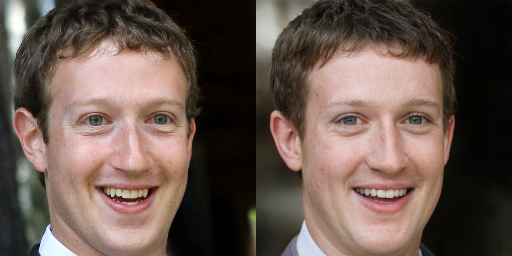

In [ ]:
img_path = 'Medvedev_and_Zuckerberg_October_2012-1.jpeg' #@param {type:"string"}

image_path = os.path.join("/content", img_path)
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents
with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

torch.save(latents, '/content/latents.pt')

from google.colab import files
files.download('/content/latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

# LICENSE

MIT License

Copyright (c) 2020-2021 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.